--- 1. Warstwa gęsta (Dense) - Klasyfikacja IRIS z optymalizatorem SGD ---
Trening modelu Dense (IRIS): 60 próbek...
Dokładność na zbiorze testowym IRIS (SGD): 0.8667


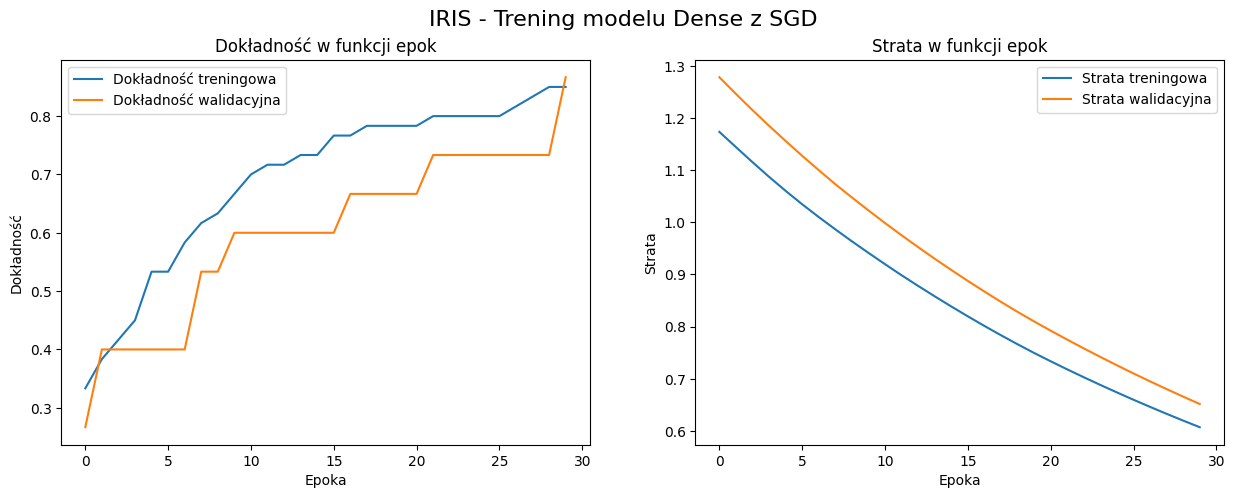


--- 2. Warstwa konwolucyjna (Conv2D) - Klasyfikacja MNIST z GlobalAveragePooling2D ---
Trening modelu CNN (MNIST): 10000 próbek...
Dokładność na zbiorze testowym MNIST (GlobalAveragePooling2D): 0.8558


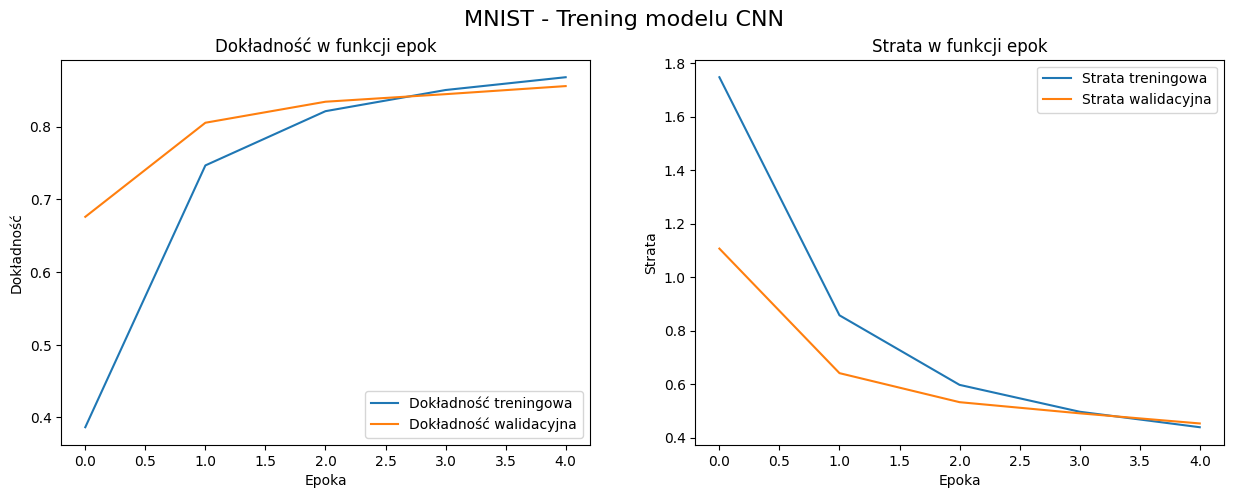


--- 3. Warstwa rekurencyjna (GRU) - Analiza sentymentu IMDB z Dwukierunkowym GRU ---
Trening modelu RNN (IMDB): 7000 próbek...
Dokładność na zbiorze testowym IMDB (Dwukierunkowe GRU): 0.8117


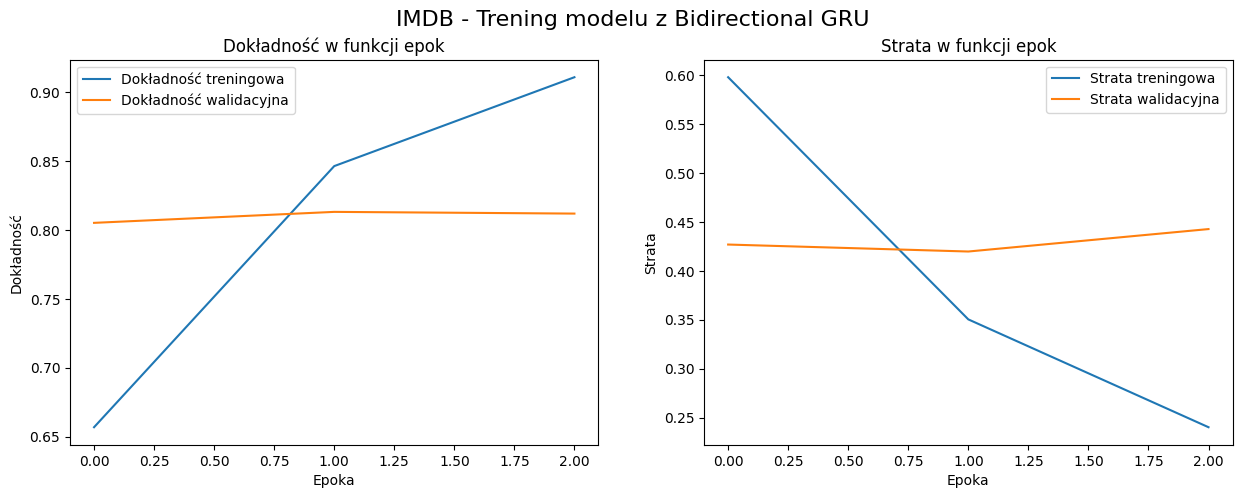


--- 4. Warstwa Transformer - Przetwarzanie sekwencji (Stacked Transformer Encoder) ---
Trening modelu Transformer: 333 próbek...
Błąd średniokwadratowy (MSE) na danych testowych (Stacked Transformer): 0.0889


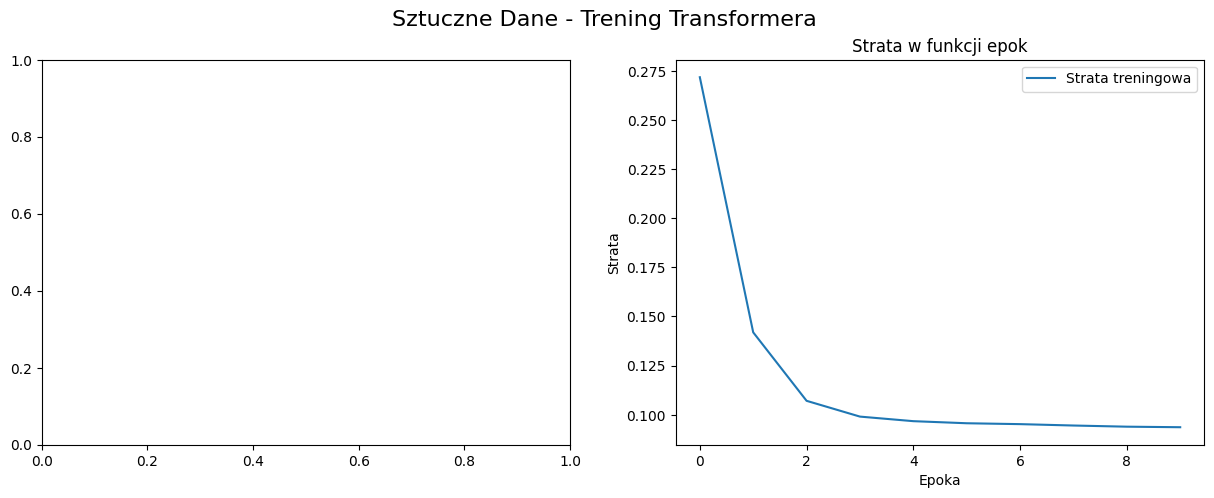

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

tf.random.set_seed(42)
np.random.seed(42)

def plot_history(history, title):
    """Wizualizacja dokładności i straty z historii treningu."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    # Wykres dokładności
    if 'accuracy' in history.history:
        ax1.plot(history.history['accuracy'], label='Dokładność treningowa')
        if 'val_accuracy' in history.history:
            ax1.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
        ax1.set_title('Dokładność w funkcji epok')
        ax1.set_ylabel('Dokładność')
        ax1.set_xlabel('Epoka')
        ax1.legend()
    
    # Wykres straty
    ax2.plot(history.history['loss'], label='Strata treningowa')
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Strata walidacyjna')
    ax2.set_title('Strata w funkcji epok')
    ax2.set_ylabel('Strata')
    ax2.set_xlabel('Epoka')
    ax2.legend()
    
    plt.show()

# 1 Warstwa gęsta - Klasyfikacja IRIS
print("--- 1. Warstwa gęsta (Dense) - Klasyfikacja IRIS z optymalizatorem SGD ---")
iris = load_iris()
X = iris.data[:75]
y = iris.target[:75]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

model_dense = models.Sequential([
    layers.Dense(10, activation='relu', input_shape=(4,)),
    layers.Dense(3, activation='softmax')
])

model_dense.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trening modelu Dense (IRIS): {len(X_train)} próbek...")
history_dense = model_dense.fit(X_train, y_train, epochs=30, verbose=0, 
                                validation_data=(X_test, y_test))
loss_d, acc_d = model_dense.evaluate(X_test, y_test, verbose=0)
print(f"Dokładność na zbiorze testowym IRIS (SGD): {acc_d:.4f}")
plot_history(history_dense, "IRIS - Trening modelu Dense z SGD")

# 2 Warstwa konwolucyjna (Conv2D) - Klasyfikacja MNIST
print("\n--- 2. Warstwa konwolucyjna (Conv2D) - Klasyfikacja MNIST z GlobalAveragePooling2D ---")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:10000] 
y_train = y_train[:10000]

x_train = x_train[..., tf.newaxis] / 255.0
x_test = x_test[..., tf.newaxis] / 255.0

model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(), 
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

print(f"Trening modelu CNN (MNIST): {len(x_train)} próbek...")
history_cnn = model_cnn.fit(x_train, y_train, epochs=5, verbose=0, 
                            validation_data=(x_test, y_test))

loss_c, acc_c = model_cnn.evaluate(x_test, y_test, verbose=0)
print(f"Dokładność na zbiorze testowym MNIST (GlobalAveragePooling2D): {acc_c:.4f}")
plot_history(history_cnn, "MNIST - Trening modelu CNN")

# 3 Warstwa rekurencyjna - Analiza sentymentu IMDB
print("\n--- 3. Warstwa rekurencyjna (GRU) - Analiza sentymentu IMDB z Dwukierunkowym GRU ---")
max_words = 10000
maxlen = 500
(x_train_r, y_train_r), (x_test_r, y_test_r) = tf.keras.datasets.imdb.load_data(num_words=max_words)

x_train_r = x_train_r[:7000] 
y_train_r = y_train_r[:7000]

x_train_r = pad_sequences(x_train_r, maxlen=maxlen)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen)

model_rnn = models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=maxlen),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

print(f"Trening modelu RNN (IMDB): {len(x_train_r)} próbek...")
# Zmniejszenie liczby epok do 3 dla szybszego wykonania
history_rnn = model_rnn.fit(x_train_r, y_train_r, epochs=3, verbose=0, 
                            validation_data=(x_test_r, y_test_r))

loss_r, acc_r = model_rnn.evaluate(x_test_r, y_test_r, verbose=0)
print(f"Dokładność na zbiorze testowym IMDB (Dwukierunkowe GRU): {acc_r:.4f}")
plot_history(history_rnn, "IMDB - Trening modelu z Bidirectional GRU")

# 4 Warstwa Transformer - Przetwarzanie sekwencji
print("\n--- 4. Warstwa Transformer - Przetwarzanie sekwencji (Stacked Transformer Encoder) ---")
seq_len = 10
feature_dim = 512

NUM_SAMPLES = 333
X_trans = np.random.rand(NUM_SAMPLES, seq_len, feature_dim).astype(np.float32)
Y_trans = np.random.rand(NUM_SAMPLES, feature_dim).astype(np.float32)

# Definicja bloku Transformera
def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res) 

    x2 = layers.Dense(ff_dim, activation="relu")(x)
    x2 = layers.Dense(inputs.shape[-1])(x2)
    x2 = layers.Dropout(dropout)(x2)
    return layers.LayerNormalization(epsilon=1e-6)(x2 + x)

# Budowa modelu
num_blocks = 2
head_size = 64
num_heads = 4
ff_dim = 128 

inputs = tf.keras.Input(shape=(seq_len, feature_dim))
x = inputs
for _ in range(num_blocks):
    x = transformer_encoder_block(x, head_size, num_heads, ff_dim, dropout=0.1)

x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(feature_dim, activation='linear')(x) 
model_trans = tf.keras.Model(inputs=inputs, outputs=outputs)
model_trans.compile(optimizer='adam', loss='mse')

print(f"Trening modelu Transformer: {NUM_SAMPLES} próbek...")
history_trans = model_trans.fit(X_trans, Y_trans, epochs=10, batch_size=32, verbose=0)

loss_t = model_trans.evaluate(X_trans, Y_trans, verbose=0)
print(f"Błąd średniokwadratowy (MSE) na danych testowych (Stacked Transformer): {loss_t:.4f}")
plot_history(history_trans, "Sztuczne Dane - Trening Transformera")